<a href="https://colab.research.google.com/github/highstreeto/akt-image-class-fh-uni/blob/master/ImageClass_FH_Uni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Needed locally

In [0]:
!pip install sklearn

In [0]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import random
import os
import sklearn.metrics as metrics

You should consider upgrading via the 'pip install --upgrade pip' command.


## Download Images

The download is documentetd here.

The images are loaded via GitHub so the same images are used.

### Install Google Image Downloader
Useful for when using Google Collabratory

In [0]:
!pip install google_images_download

### Download

* Keywords are: `fh gebaeude oesterreich` and `universitaet gebaeude oesterreich`
* Umlaute are not recognized by downloader so use ae, etc. instead

In [0]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()
fh_images = response.download({"keywords": "fh gebaeude oesterreich", "output_directory": "drive/My Drive/AKT"})

SyntaxError: ignored

In [0]:
uni_images = response.download({"keywords": "universitaet gebaeude oesterreich", "output_directory": "drive/My Drive/AKT"})


Item no.: 1 --> Item name = universitaet gebaeude oesterreich
Evaluating...
Starting Download...
Completed Image ====> 1.1200px-Wien_-_Universit%C3%A4t_%283%29.JPG
URLError on an image...trying next one... Error: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)>
Completed Image ====> 2.UniWien.jpg
Completed Image ====> 3.Technische_Universit%C3%A4t_Wien_mainbuilding_mainentrance_northview_.jpg
Completed Image ====> 4.Universit%C3%A4t_Geb%C3%A4ude.jpg
Completed Image ====> 5.gebaude-der-bibliothek-der-tu-wien-universitat-in-wien-osterreich-mkhmjx.jpg
Completed Image ====> 6.technische-universitat-tu-wien-gebaude-in-wien-osterreich-mkhmjt.jpg
URLError on an image...trying next one... Error: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)>
URLError on an image...trying next one... Error: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)>
Completed Image ====> 7.Fakult%C3%A4t_

## Import images from GitHub


In [0]:
!git clone -l -s https://github.com/highstreeto/akt-image-class-fh-uni.git data
!ls

/bin/sh: 1: git: not found
ImageClass_FH_Uni.ipynb  README.md  Start-NotebookDocker.ps1  test  train


# Training Data

In [0]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

def plotImages(images_arr, size):
    fig, axes = plt.subplots(1, size, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
  
def class_idx_to_name(class_idx):
  if (class_idx == 0):
    return "FH"
  else:
    return "Uni"

## ImageDataGenerator
* Do not use vertical flip, as up-side down buildings make no sense

In [0]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
	rescale=1./255,
	rotation_range=25,
	width_shift_range=0.1,
	height_shift_range=0.1,
	brightness_range=(0.9, 1.1),
	horizontal_flip=True,
	vertical_flip=False
)

test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

In [0]:
if os.path.isdir("./data"):
	train_dir = "./data/train/"
	test_dir = "./data/test/"
else:
	train_dir = "./train/"
	test_dir = "./test/"

IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

train_data_gen = train_image_generator.flow_from_directory(
	batch_size=batch_size,
	directory=train_dir,
	shuffle=True,
	target_size=(IMG_HEIGHT, IMG_WIDTH),
	subset="training"
)

validation_data_gen = train_image_generator.flow_from_directory(
	batch_size=batch_size,
	directory=train_dir,
	shuffle=True,
	target_size=(IMG_HEIGHT, IMG_WIDTH),
	subset="validation"
)

test_data_gen = test_image_generator.flow_from_directory(
	batch_size=batch_size,
  directory=test_dir,
  target_size=(IMG_HEIGHT, IMG_WIDTH))

print(train_data_gen.class_indices)
print(validation_data_gen.class_indices)
print(test_data_gen.class_indices)

Found 183 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
{'fh gebaeude oesterreich': 0, 'universitaet gebaeude oesterreich': 1}
{'fh gebaeude oesterreich': 0, 'universitaet gebaeude oesterreich': 1}
{'fh gebaeude oesterreich': 0, 'universitaet gebaeude oesterreich': 1}


In [0]:
sample_training_images, _ = next(skip_broken_images(train_data_gen))
plotImages(sample_training_images, 12)

# Callbacks

In [0]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots",
    verbose=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
		monitor="loss",
		min_delta=0.001,
		patience=6
)

# Network ResNet50V2

In [0]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
	include_top=False,
	pooling='max',
	input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
	weights='imagenet')

model = tf.keras.Sequential([
	base_model,
	tf.keras.layers.Dense(512, 'relu'),
	tf.keras.layers.Dense(256, 'relu'),
	tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])
model.summary()
model.save("model.h5")

## Training
* Train only last layer to preserve learned weights (buildings should be known by ResNet)
* Use 3 steps per epoch as we have a batch size of 32 and ~100 images per class (images / batch size)
* Use EarlyStoppingCallback to stop learning

In [0]:
for layer in base_model.layers:
	layer.trainable = False
  
model.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['categorical_accuracy'])

history = model.fit_generator(
	skip_broken_images(train_data_gen),
	steps_per_epoch=3,
	epochs=100,
	callbacks=[early_stopping_callback]
)

In [0]:
plt.figure(figsize=(15,5))
plt.subplot(1,2, 1)
plt.plot(history.history['loss'])
plt.legend(['loss'])

plt.subplot(1,2, 2)
plt.plot(history.history['categorical_accuracy'], scaley=False)
plt.legend(['categorical_accuracy'])

## Evaluate

In [0]:
y_pred = model.predict_generator(test_data_gen, steps=test_data_gen.samples / batch_size)
y_pred = np.argmax(y_pred, axis=1)

y_true = test_data_gen.classes

c_matrix = metrics.confusion_matrix(y_true, y_pred)
print(c_matrix)

# auc/roc
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
auc = metrics.auc(fpr, tpr)

print("auc: ", auc)

## Test with one batch

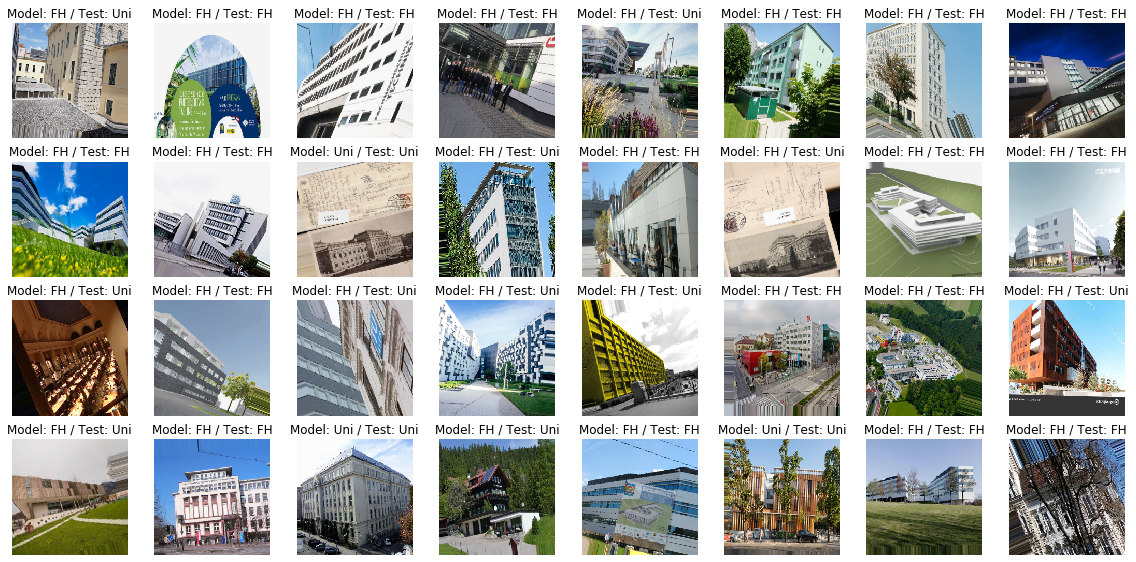

In [0]:
plt.figure(figsize=(20,20))
batch = next(skip_broken_images(train_data_gen))
for i, img in enumerate(batch[0]):
  # ResNet takes natches of images to classify so create new batch array with one image
  model_input = np.zeros((1, 224, 224, 3), dtype=float)
  model_input[0] = img

  pred = np.argmax(model.predict(model_input)[0])
  test = np.argmax(batch[1][i])

  plt.subplot(8,8, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title("Model: %s / Test: %s" % (class_idx_to_name(pred), class_idx_to_name(test)))